<a href="https://colab.research.google.com/github/aminahelmustafa/linear-regression-from-scratch/blob/main/SGD/BGD%20%26%20Minibatch%20GD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import libraries 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
from ipywidgets import interact
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from random import shuffle
%matplotlib inline


#Read the data from UCL Repositry





In [ ]:
!mkdir data
!wget -P data https://archive.ics.uci.edu/ml/machine-learning-databases/00294/CCPP.zip


--2021-02-28 19:06:23--  https://archive.ics.uci.edu/ml/machine-learning-databases/00294/CCPP.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3674852 (3.5M) [application/x-httpd-php]
Saving to: ‘data/CCPP.zip’

CCPP.zip            100%[===================>]   3.50M  6.85MB/s    in 0.5s    

2021-02-28 19:06:24 (6.85 MB/s) - ‘data/CCPP.zip’ saved [3674852/3674852]



In [ ]:
os.chdir ('/content/data/')

In [ ]:
!unzip CCPP.zip

Archive:  CCPP.zip
   creating: CCPP/
  inflating: CCPP/Folds5x2_pp.ods    
  inflating: CCPP/Folds5x2_pp.xlsx   
  inflating: CCPP/Readme.txt         
  inflating: CCPP/Readme.txt~        


In [ ]:
path='/content/data/CCPP/'

In [ ]:
##reading the data 
data=pd.read_excel(f"{path}Folds5x2_pp.xlsx")

In [ ]:
#checking the head of the data 
data.head()

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


In [ ]:
#just try splitting to x and y and see how it looks like 
x=data.iloc[:,:-1] 
y=pd.DataFrame(data.iloc[:,-1:])
x.head()

,AT,V,AP,RH
0,14.96,41.76,1024.07,73.17
1,25.18,62.96,1020.04,59.08
2,5.11,39.40,1012.16,92.14
3,20.86,57.32,1010.24,76.64
4,10.82,37.50,1009.23,96.62


In [ ]:
y.head()

,PE
0,463.26
1,444.37
2,488.56
3,446.48
4,473.90


#Visualizing the data


/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


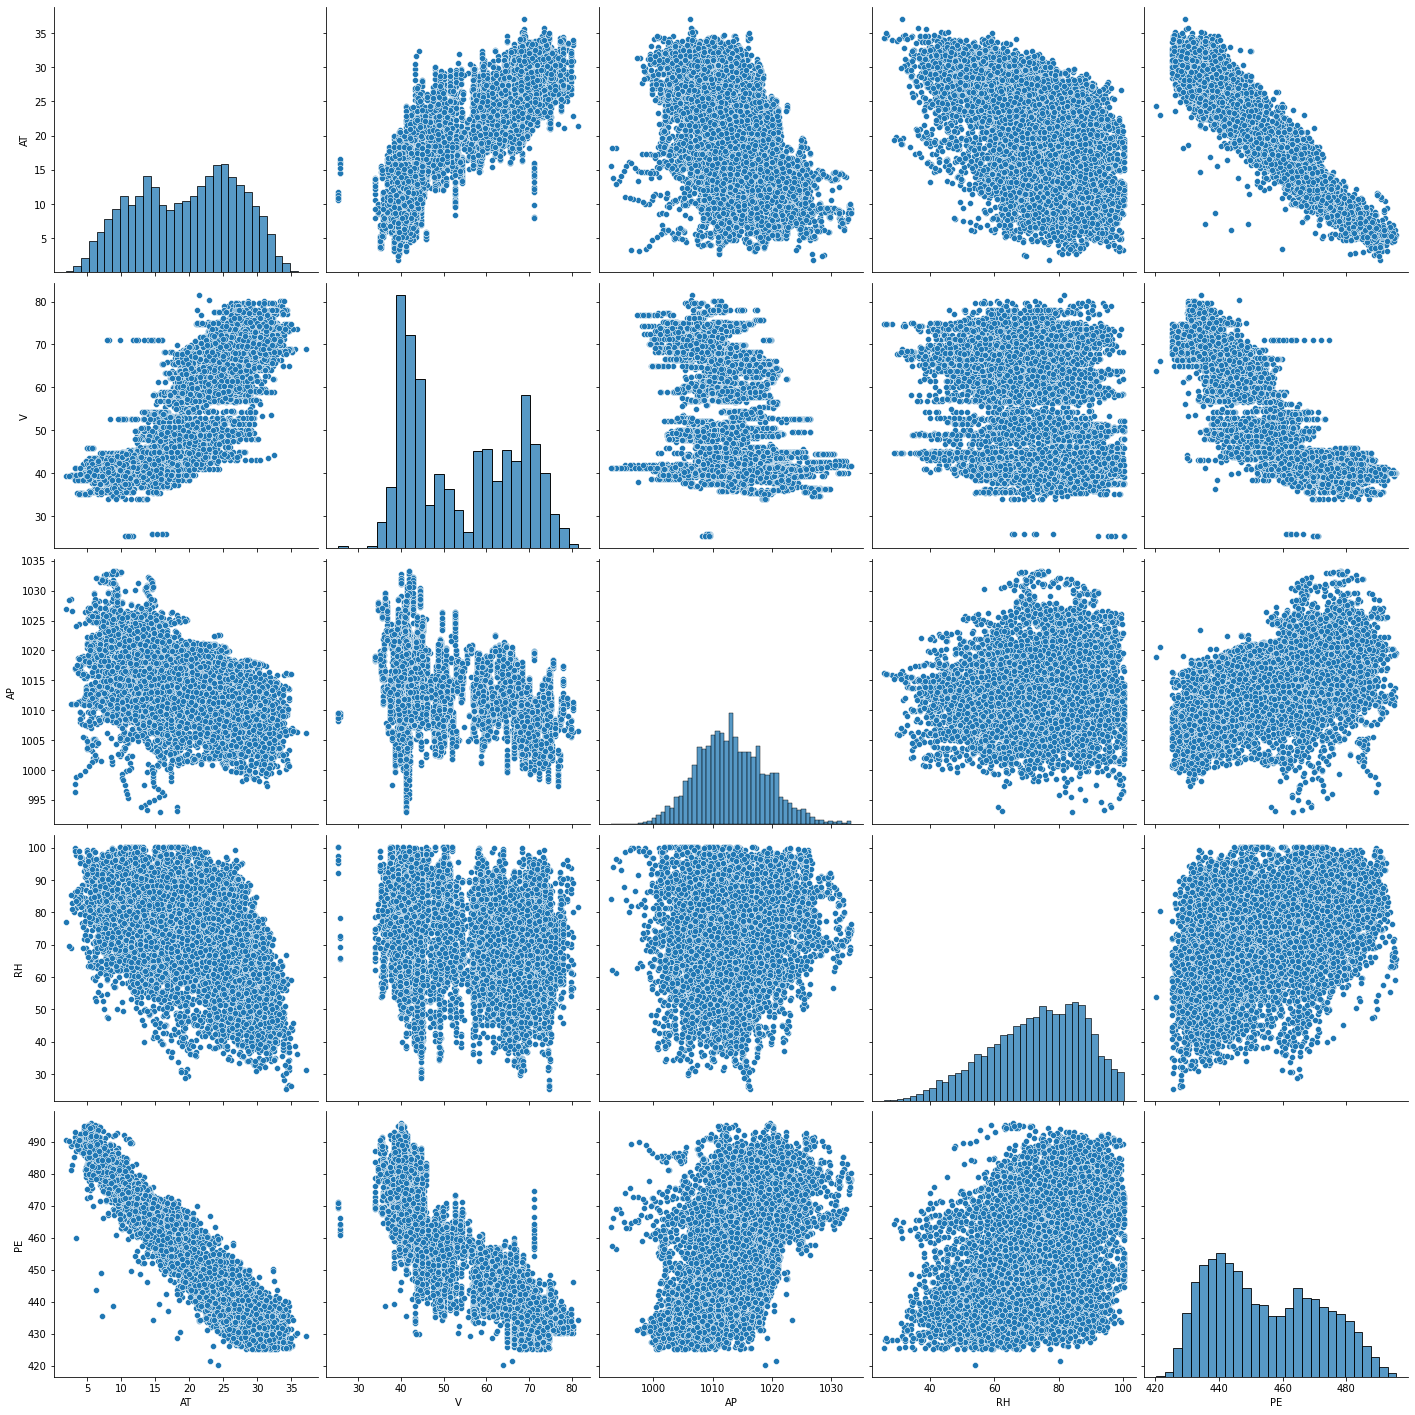

In [ ]:
#using pair plot to plot correlation between different features and the target
sns.pairplot(data=data,size=4)

#Analysis
Noticing the last raw of plots( features vs target) we can see that AT & V are more negativly correlated to the output than other features  but other features (AP & RH ) are also somehow correlated to the output so we cannot remove any of them.Also features are not correlated against each other so we have to use all of them.

#Preprocessing

In [ ]:
#rescaling data into standard normal distribution (between -3 and 3):
def standardize(data):
  return (data-data.mean())/data.std()

In [ ]:
#normalizing data between -1 and 1 :
def normalize(data):
  return (data-data.mean())/(data.max()-data.min())

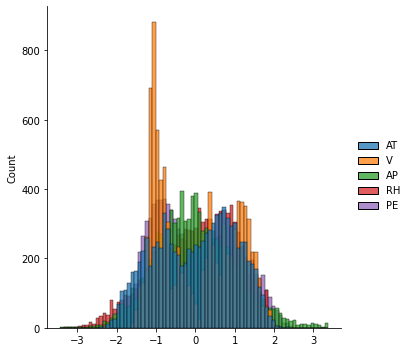

In [ ]:
#visualizing the standardized  data 
data2=standardize(data)
data2.head()
sns.displot(data2)

we can observe the distribution of the data now looks alike to a standard normal distribution with some skewness 

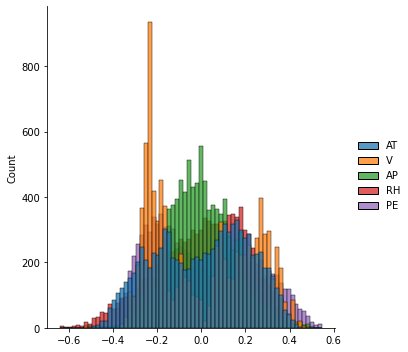

In [ ]:
#visualizing the normalized  data 
data3=normalize(data)
data3.head()
sns.displot(data3)

we can see the distribution is similar  to  standard normal one with just difference in range of values 

#splitting the data 

In [ ]:
#splitting data to train/test depending on the passed ratio parameter after rescaling the data using standardization or normalizaion
def dataloader(data,ratio,scaling='standard'):
  #scaling before splitting 
    if scaling=='standard':
      data=standardize(data)
    if scaling=='normal':
      data=normalize(data)
    #sampling into train and test
    dataTrain=data.sample(frac=ratio,random_state=200)
    dataTest=data.drop(dataTrain.index)
    # splitting x and y
    trainX=dataTrain.iloc[:,:-1]
    trainY=dataTrain.iloc[:,-1:]
    testX=dataTest.iloc[:,:-1]
    testY=dataTest.iloc[:,-1:]
    
    
    return trainX,trainY,testX,testY

In [ ]:
#checking the shape
trainX,trainY,testX,testY=dataloader(data,0.8)
trainX.shape, trainY.shape,testX.shape,testY.shape

((7654, 4), (7654, 1), (1914, 4), (1914, 1))

In [ ]:
type(trainY)

pandas.core.frame.DataFrame

In [ ]:
#checking the train split:
trainX.head()

,AT,V,AP,RH
2102,-0.393323,-0.784222,1.010463,-0.653343
8345,1.113559,1.510415,-0.478057,-1.047856
645,0.186350,-0.725203,0.156753,-2.238930
429,0.096447,-0.177512,-0.154759,-0.735533
3017,-0.502012,1.324704,1.084552,-0.045135


#linear Regression model implemntation with Gradient Descent

In [ ]:
np.random.choice?

In [ ]:
class LinearRegression:
  def __init__(self,lr,num_iter,error=0.1,lamda1=0,lamda2=0):
    '''
    parameters of constructor :learning rate, num of iteration , percision(error), regularization terms (l1 & l2)
    theta parameter is class variable
    '''
    LinearRegression.theta=0
    self.lr=lr
    self.num_iter=num_iter
    self.error=error
    self.lamda1=lamda1
    self.lamda2=lamda2
  def fitBGD(self,x,y):
    '''
    fucntion :fitting the data using batch GD
    parameters:features(x),target(y) passed as dataframe NOT arrays 
    returns: theta parameter as column vector & number of iterations & loss vector 
    '''
    ####initializing #####
    iter=0
    theta=previous_theta=np.random.randn(x.shape[1],1)
    percision=100 
    regularization1=self.lamda2 ###l2 norm
    regularization2=self.lamda1 ##l1 norm
    loss=[]
    size=x.shape[0]
    while (iter<self.num_iter  or percision.max()>self.error):
      previous_theta=theta
      
      #theta calc 
      sign=theta/abs(theta)
      theta=theta-self.lr*(2/size)*(x.values.T.dot(x.values.dot(theta) - y.values.reshape(size,1))+regularization1*theta+(sign*regularization2))
      loss.append( ((y.values.reshape(size,1)-x.values.dot(theta))**2).mean())
    
      percision=abs(theta-previous_theta)
      
      iter+=1
    LinearRegression.theta=theta
    return theta,iter,loss
  def fitSGD(self,x,y):
    '''
    fucntion :fitting the data using Stochastic GD
    parameters:features(x),target(y) passed as dataframe NOT arrays 
    returns: theta parameter as column vector & number of iterations & loss vector 
    '''
    ####initializing #####
    size=len(x)
    iter=0
    theta=previous_theta=np.random.randn(x.shape[1])
    regularization1=self.lamda2 ###l2 norm
    regularization2=self.lamda1 ##l1 norm
    percision=100
    loss=[]
    while (iter<self.num_iter or percision>self.error ):
       previous_theta=theta
       for k in range(size):
         i=np.random.choice(range(len(x)))
             #theta calc
         cost=x.values[i].dot(theta)- y.values[i]
        
         gradient=x.values[i]*(cost)
         sign=theta/abs(theta)
         theta=theta - self.lr*(2/size)*(gradient+regularization1*theta+ (sign*regularization2))
          
        
    #  ##mean squared cost function
         loss.append( ((y.values[i]-x.values[i].dot(theta))**2).mean())
    
    
       percision=np.linalg.norm(theta-previous_theta)
       iter+=1
    LinearRegression.theta=theta.reshape((x.shape[1],1))
    return LinearRegression.theta,iter,loss
    '''
    while (iter<self.num_iter and percision >self.error ):
      previous_theta=theta
      i=np.random.choice(range(len(x)), replace=False)
            #theta calc
      cost=x.values[i].dot(theta)- y.values[i]
        
      gradient=x.values[i]*(cost)
      theta=theta - self.lr*(2/size)*(gradient+regularization1*theta+ regularization2)
        
        
     ##mean squared cost function
      loss.append( ((y.values.reshape(size,1)-x.values.dot(theta))**2).mean())
    
    
      percision=np.linalg.norm(theta-previous_theta)
      iter+=1
    LinearRegression.theta=theta.reshape((x.shape[1],1))

    return LinearRegression.theta,iter,loss
    '''
  def createMiniBatch(self,x,y,batchsize):
     '''
    Helper fucntion :creating mini batches of your data
    parameters:features(x),target(y) passed as dataframe NOT arrays ,batchsize in powers of 2
    returns: x and y mini batches (as a series type)
    '''
     size=x.shape[0]
     
     indxlist=list(range(size))
     ###shuffling 
     shuffle(indxlist)
     ###no of batches depending on the patch size
     n_mini_batches=size//batchsize
     for i in range(n_mini_batches+1):
        
         ###check if there is leftovers of samples that isnot visited yet
        if i==n_mini_batches and size%batchsize !=0:
          
          yield x.iloc[i*batchsize:size,:],y.iloc[i*batchsize:size,:]
        else:
         
          idx=indxlist[i*batchsize:(i+1)*batchsize]
         
          yield x.iloc[idx,:],y.iloc[idx,:]
      


  def fitMBGD(self,x,y,batchsize):
    '''
    fucntion :fitting the data using Minibatch GD
    parameters:features(x),target(y) passed as dataframe NOT arrays ,batchsize in powers of 2
    returns: theta parameter as column vector & number of iterations & loss vector 
    '''
    ####creating mini batches :#####

 
    iter=0
    theta=previous_theta=np.random.randn(x.shape[1],1)
    percision=100
    regularization1=self.lamda2 ###l2 norm
    regularization2=self.lamda1 ##l1 norm
    loss=[]
    size=x.shape[0]
   
    while (iter<self.num_iter or percision>self.error):
      
      previous_theta=theta
     
      for batch in self.createMiniBatch(x,y,batchsize):
        
        xb, yb=batch
        cost=xb.values.dot(theta) - yb.values.reshape(len(yb),1)
        gradient=xb.values.T.dot(cost)
        sign=theta/abs(theta)
        theta=theta-self.lr*(2/size)*((gradient+regularization1*theta+ (sign*regularization2)))
      loss.append( ((y.values.reshape(size,1)-x.values.dot(theta))**2).mean())
      percision=np.linalg.norm(theta-previous_theta)
      iter+=1
    LinearRegression.theta=theta
    return theta,iter,loss
  def predict(self,x):
    '''
    fucntion :predicting the data using the model thetas 
    parameters:features(x) to predict passed as dataframe NOT arrays 
    returns: predictions (ypredict) 
    '''
    return x.dot(LinearRegression.theta).values
  def rmse(self,ytarg,ypred):
    '''
    fucntion :calculating the criteria root mean square error
    parameters:ytraget and ypredicted 
    returns: rmse value 
    '''
    return np.sqrt((np.sum((ytarg-ypred)**2))/ytarg.shape)[0]
  
    def add_ones(self,x):
      '''
    fucntion :add bias term(intercept)
    parameters:features
    returns: features with add bias term
    '''
    bias=np.ones((x.shape[0],1))
    return np.concatenate((x,bias),axis=1)
   
  
  











In [ ]:

###test the above class:
## instantiate the  model without regularization 
model=LinearRegression(lr=0.01,num_iter=1000)

#BGD fitting

[[-1.09341678e+00]
 [-5.79412821e-04]
 [-2.08222258e-02]
 [-2.09404124e-01]]
1000


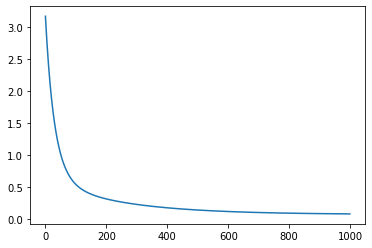

In [ ]:

thetas,iter,loss=model.fitBGD(trainX,trainY)
print(thetas)
print(iter)
plt.plot(loss)

In [ ]:
print(model.predict(testX))

[[ 1.86791927]
 [-0.21467617]
 [-0.75919774]
 ...
 [ 1.31776477]
 [ 1.70927129]
 [-0.93878537]]


In [ ]:
testY

,PE
2,2.003574
3,-0.462003
5,-0.626649
7,1.409445
17,1.337962
...,...
9522,0.129196
9533,-0.784849
9536,1.155739
9538,1.762759


#BGD RMSE over the test data

In [ ]:
model.rmse(testY.values,model.predict(testX))

0.2619109728195087

#SGD Fitting

[[-0.10283517]
 [-0.16422013]
 [ 1.05531273]
 [ 0.45467457]]


Text(0, 0.5, 'loss')

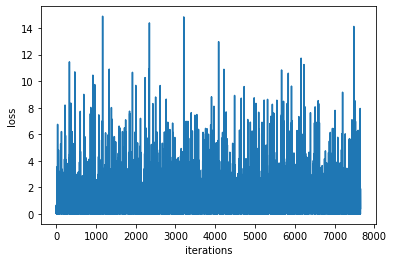

In [ ]:
thetas,iter,loss=model.fitSGD(trainX,trainY)
print(thetas)
plt.plot(loss)
plt.xlabel('iterations')
plt.ylabel('loss')



In [ ]:
iter

1

#SGD RMSE


In [ ]:
model.rmse(testY.values,model.predict(testX))

0.6356556575030669

#Mini batch fitting

1000
[[-0.70492466]
 [-0.28679745]
 [ 0.05446976]
 [-0.08328418]]


Text(0, 0.5, 'loss')

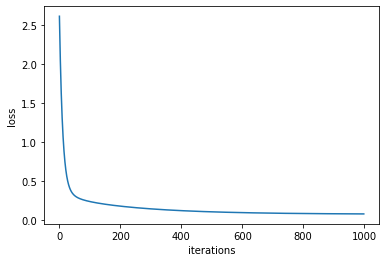

In [ ]:
thetas,iter,loss=model.fitMBGD(trainX,trainY,batchsize=1024)
print(thetas)
plt.plot(loss)
plt.xlabel('iterations')
plt.ylabel('loss')

#Mini batch RMSE

In [ ]:
model.rmse(testY.values,model.predict(testX))

1.2861168463268366

#observations:
BGD & MBGD convergance  is very similar but BGD has faster run time 
SGD convergence is random and goes up and down & not that fast.All of them have simialr values for the parameters .

#Regularization

In [ ]:
##part3:adding regularization term first l1 norm:

In [ ]:
model2=LinearRegression(lr=0.1,num_iter=10,lamda1=20)

In [ ]:
##BGD model
model2.fitBGD(trainX,trainY)[0]

array([[-0.80848707],
       [-0.20305365],
       [ 0.03926896],
       [-0.11324577]])

difference between rmse train and test to check for overfitting if any after regularization l1

In [ ]:
model2.rmse(trainY.values,model2.predict(trainX))

0.2694337422477331

In [ ]:
model2.rmse(testY.values,model2.predict(testX))

0.2625961460349055

In [ ]:
##SGD model
model2.fitSGD(trainX,trainY)[0]

array([[-102.78778493],
       [  22.76156965],
       [ -55.52026874],
       [ -61.98573729]])

checking the difference between train rmse and test rmse to test for overfitting


In [ ]:
model2.rmse(trainY.values,model2.predict(trainX))

0.8936605400596321

In [ ]:
model2.rmse(testY.values,model2.predict(testX))

0.9006353547105455

In [ ]:
##MBGD fitting with l1
model2.fitMBGD(trainX,trainY,batchsize=128)
###checking the difference between train rmse and test rmse to test for overfitting
model2.rmse(testY.values,model2.predict(testX))-model2.rmse(trainY.values,model2.predict(trainX))

0.0024110897743429005

#Difference between different regularization terms using MBGD in terms of RMSE between train and test

In [ ]:
#adding l1 norm:
model2=LinearRegression(lr=0.1,num_iter=1000,lamda1=10)
print('model weights: ')
print(model2.fitBGD(trainX,trainY))

print('difference in train and test rmse when using l2 regularizer & BGD is ')
print(model2.rmse(testY.values,model2.predict(testX))-model2.rmse(trainY.values,model2.predict(trainX)))
print('RMSE of test  : ')
print(model2.rmse(testY.values,model2.predict(testX)))

model weights: 
(array([[-0.86593982],
       [-0.17106327],
       [ 0.02101021],
       [-0.13750422]]), 1000)
difference in train and test rmse when using l2 regularizer & BGD is 
-0.008112337650341583
RMSE of test  : 
0.2605180699586044


In [ ]:
#adding l2 norm:
model3=LinearRegression(lr=0.1,num_iter=1000,lamda2=10)
print('model weights: ')
print(model3.fitBGD(trainX,trainY))

print('difference in train and test rmse when using l2 regularizer & BGD is ')
print(model3.rmse(testY.values,model3.predict(testX))-model3.rmse(trainY.values,model3.predict(trainX)))
print('RMSE of test  : ')
print(model3.rmse(testY.values,model3.predict(testX)))

model weights: 
(array([[-0.85295839],
       [-0.17637315],
       [ 0.02606159],
       [-0.13121313]]), 1000)
difference in train and test rmse when using l2 regularizer & BGD is 
-0.007730435656757517
RMSE of test  : 
0.2608801544552046


In [ ]:
#adding Elastic Net norm:
model4=LinearRegression(lr=0.1,num_iter=1000,lamda1=5,lamda2=10)
model4.fitBGD(trainX,trainY)
print('difference in train and test rmse when using elastic net regularizer  & BGD is')
print(model4.rmse(testY.values,model4.predict(testX))-model4.rmse(trainY.values,model4.predict(trainX)))
print('RMSE of test  : ')
print(model4.rmse(testY.values,model4.predict(testX)))

difference in train and test rmse when using elastic net regularizer  & BGD is
-0.007868366789307468
RMSE of test  : 
0.26073574833333285


#observation:
there is no signigicant difference in rmse difference for different regualrizers maybe because the model is simple and the data doesn't have high variance

#Lambada against Weights norm

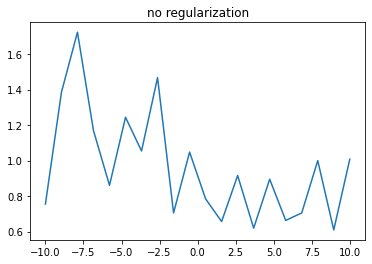

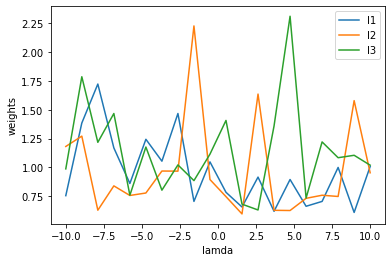

In [ ]:
#using minibatch learning algorithm
lamdarange=np.linspace(-10,10,20)
norm=[]
norm1=[]
norm2=[]
norm3=[]
for lamda in lamdarange:
  model=LinearRegression(lr=0.001,num_iter=10)
  model1=LinearRegression(lr=0.001,num_iter=1000,lamda1=lamda)
  model2=LinearRegression(lr=0.001,num_iter=1000,lamda2=lamda)
  model3=LinearRegression(lr=0.001,num_iter=1000,lamda1=lamda,lamda2=lamda)
  norm.append(np.linalg.norm(model.fitBGD(trainX,trainY)[0]))
  norm1.append(np.linalg.norm(model1.fitBGD(trainX,trainY)[0]))
  norm2.append(np.linalg.norm(model2.fitBGD(trainX,trainY)[0]))
  norm3.append(np.linalg.norm(model3.fitBGD(trainX,trainY)[0]))
  
#print(norm1)
plt.figure()
plt.plot(lamdarange,norm1,label='zero reg')
plt.title('no regularization')
plt.figure()
plt.plot(lamdarange,norm1,label='l1')
plt.plot(lamdarange,norm2,label='l2')
plt.plot(lamdarange,norm3,label='l3')
#sns.relplot(norm2,list(lamda))
#sns.relplot(norm3,list(lamda))
plt.xlabel('lamda')
plt.ylabel('weights')
plt.legend()

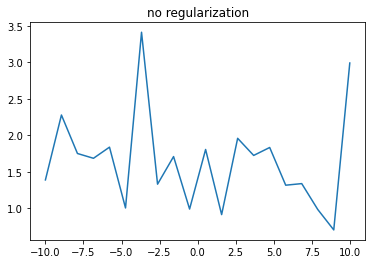

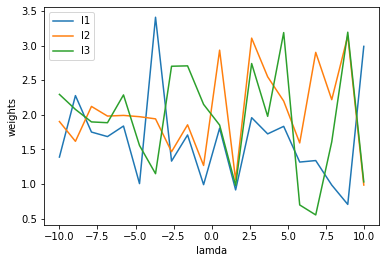

In [ ]:
#using SGD learning algorithm
lamdarange=np.linspace(-10,10,20)
norm=[]
norm1=[]
norm2=[]
norm3=[]
for lamda in lamdarange:
  model=LinearRegression(lr=0.001,num_iter=5)
  model1=LinearRegression(lr=0.001,num_iter=1,lamda1=lamda)
  model2=LinearRegression(lr=0.001,num_iter=1,lamda2=lamda)
  model3=LinearRegression(lr=0.001,num_iter=1,lamda1=lamda,lamda2=lamda)
  norm.append(np.linalg.norm(model.fitSGD(trainX,trainY)[0]))
  norm1.append(np.linalg.norm(model1.fitSGD(trainX,trainY)[0]))
  norm2.append(np.linalg.norm(model2.fitSGD(trainX,trainY)[0]))
  norm3.append(np.linalg.norm(model3.fitSGD(trainX,trainY)[0]))
  
#print(norm1)
plt.figure()
plt.plot(lamdarange,norm1,label='zero reg')
plt.title('no regularization')
plt.figure()
plt.plot(lamdarange,norm1,label='l1')
plt.plot(lamdarange,norm2,label='l2')
plt.plot(lamdarange,norm3,label='l3')
#sns.relplot(norm2,list(lamda))
#sns.relplot(norm3,list(lamda))
plt.xlabel('lamda')
plt.ylabel('weights')
plt.legend()

#observation:
although the difference is tiny for this data and this hyperparameters, the l1 norm shrinks weights more in larger values of l1, in smaller variables there is no noticable difference.as for elastic net it has the greater slope and effect on shrinking the weight.

#No of Epochs hyper paramerter tuning

In [ ]:
#this fucntion can be removed:
def train(data,model,batch,splitsize=0.8,epochs=2):
  '''
  function :train different epochs sizes of the data and plot the rmse test and train agains those epochs
  parameters:data frame , number of epochs , your linear model, batch size and split size
  returns:mean train and test across different epochs
  '''
  trainX,trainY,testX,testY=dataloader(data,splitsize)
  rmse_train=[]
  rmse_test=[]

 
  for epoch in range(epochs):
      model.fitMBGD(trainX,trainY,batchsize=batch)
      rmse_train.append(model.rmse(trainY.values,model.predict(trainX)[0]))
      rmse_test.append(model.rmse(testY.values,model.predict(testX)[0]))

 
  plt.plot(range(epochs), rmse_train,label='train rmse')
  plt.plot(range(epochs), rmse_test,label='test rmse')
  plt.xlabel('epoch')
  plt.ylabel('rmse')
  plt.legend()
  return np.mean(rmse_train),np.mean(rmse_test)

In [ ]:
#step4:
def trainwithoutPlot(data,epochs,model,batch,splitsize=0.8):
  '''
  function :train different epochs sizes of the data and plot the rmse test and train agains those epochs
  parameters:data frame , number of epochs , your linear model, batch size and split size
  returns:rmse values of train , test and the mean of these values
  '''
  trainX,trainY,testX,testY=dataloader(data,splitsize)
  rmse_train=[]
  rmse_test=[]

 
  for epoch in range(epochs):
      model.fitMBGD(trainX,trainY,batchsize=batch)
      rmse_train.append(model.rmse(trainY.values,model.predict(trainX)[0]))
      rmse_test.append(model.rmse(testY.values,model.predict(testX)[0]))

  return rmse_train,rmse_test,np.mean(rmse_train),np.mean(rmse_test)

(1.3953333257193392, 1.7834551945335704)

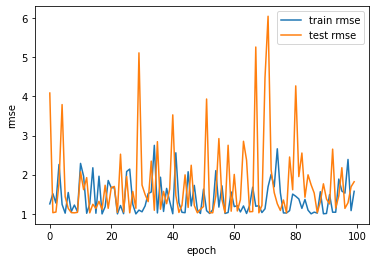

In [ ]:
#testing train and test over 100 epochs :
model=LinearRegression(lr=0.01,num_iter=10)
train(data,model,batch=256,epochs=100)

#observation
 Test error is way higher than train maybe the model is overfitting,also , test error has  more randomness , this is maybe due to ??.

#Split size effect on RMSE

In [ ]:
def train_split(data,model,batch,splitsize=0.8,epochs=10):
  '''
  function :train different splits size of the data and plot the rmse test and train agains different split sizes
  parameters:data frame , number of epochs , your linear model, batch size and split size
  returns:rmse train and test
  '''

  for split in list(splitsize):
    rmse_train=[]
    rmse_test=[]
    trainX,trainY,testX,testY=dataloader(data,split)
    for epoch in range(epochs):
      model.fitMBGD(trainX,trainY,batchsize=batch)
      rmse_train.append(model.rmse(trainY.values,model.predict(trainX)[0]))
      rmse_test.append(model.rmse(testY.values,model.predict(testX)[0]))

    figure=plt.figure(figsize=(4,4))
    plt.yscale('log')
    plt.plot(range(epochs), rmse_train,label='train rmse split {:.2f}'.format(split))
    plt.plot(range(epochs), rmse_test,label=f'test rmse')
    plt.xlabel('epoch')
    plt.ylabel('rmse')
    plt.legend()
  return rmse_train,rmse_test

train error is [2.922597492641361, 1.0366361817982934, 1.3178352180502104, 1.020389871134866, 0.9979128807767188, 2.677196042594473, 1.7652960686055807, 1.066595203760604, 1.7777782135930669, 3.4843556131580082]
test error is [2.5916655833883686, 3.9676823087699407, 1.1085115432048727, 1.1069740536083377, 1.193713750417827, 3.6423254052718326, 1.0585565800622936, 4.645750383103188, 2.075451151927057, 1.3956526068730675]


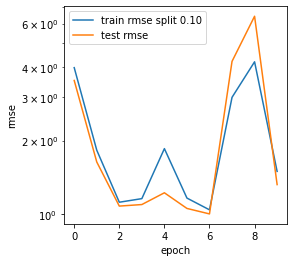

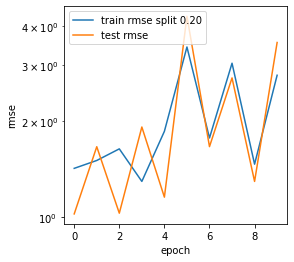

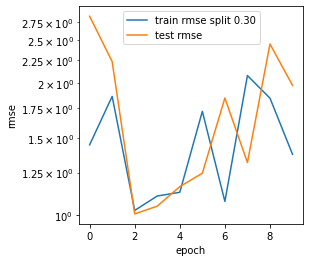

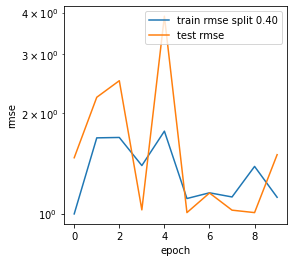

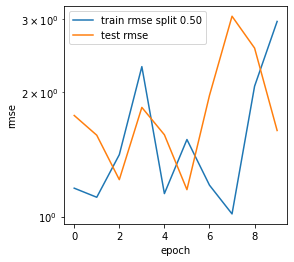

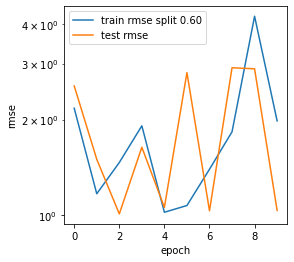

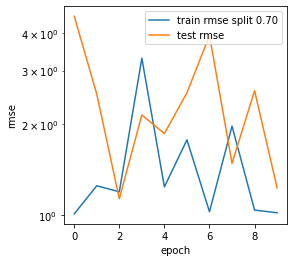

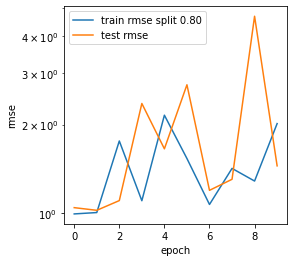

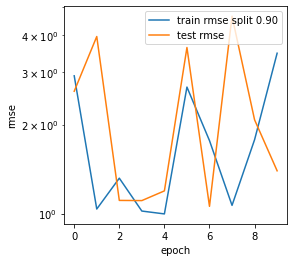

In [ ]:
#testing:
model=LinearRegression(lr=0.001,num_iter=1,lamda2=10)
train, test=train_split(data,model,splitsize=np.linspace(0.1,0.9,9),batch=256,epochs=10)
print(f'train error is {train}')
print(f'test error is {test}')

#observation 
the ideal is that the model should generalize better when we increase the training data(split ratio in this case) but what can be seen from here is ??

#Featurn engineering

In [ ]:
###feature engineering::::::::
#creating new features:
def featureEngineering(df,feature_power,standardize=False):
  '''
  function :reutrns a data frame that has features added to it , square polynomial of the original features, cubic or 4th degree one 
  parameters: data frame that is not standardaized yet , the power of your polynomial [2,3,4] the defalut option is polynomial of power 2 plus 3
  returns:standardized data frame after adding features to it
  '''
  df2=df.copy()
  for column in df2.columns[:-1]:
    if feature_power==2:
      df2[f'{column}^{feature_power}']=df[column].apply(lambda x: x**feature_power)
    elif feature_power==3:
      df2[f'{column}^{feature_power-1}']=df[column].apply(lambda x: x**feature_power-1)
      df2[f'{column}^{feature_power}']=df[column].apply(lambda x: x**feature_power)
    elif feature_power==4:
      df2[f'{column}^{feature_power-2}']=df[column].apply(lambda x: x**feature_power-2)
      df2[f'{column}^{feature_power-1}']=df[column].apply(lambda x: x**feature_power-1)
      df2[f'{column}^{feature_power}']=df[column].apply(lambda x: x**feature_power)
    else:
       df2[f'{column}^2+{column} ^3']=df[column].apply(lambda x: x**2+x**3)

  if standardize:
      df2=standardize(df2)
  

    
  return df2


In [ ]:
#testing feature engineering:
featureEngineering(data,3)


,AT,V,AP,RH,PE,AT^2,AT^3,V^2,V^3,AP^2,AP^3,RH^2,RH^3
0,14.96,41.76,1024.07,73.17,463.26,3347.071936,3348.071936,72824.163776,72825.163776,1.073962e+09,1.073962e+09,391740.124013,391741.124013
1,25.18,62.96,1020.04,59.08,444.37,15963.935832,15964.935832,249570.022336,249571.022336,1.061333e+09,1.061333e+09,206214.573312,206215.573312
2,5.11,39.40,1012.16,92.14,488.56,132.432831,133.432831,61161.984000,61162.984000,1.036925e+09,1.036925e+09,782247.292344,782248.292344
3,20.86,57.32,1010.24,76.64,446.48,9076.012056,9077.012056,188328.583168,188329.583168,1.031036e+09,1.031036e+09,450158.570944,450159.570944
4,10.82,37.50,1009.23,96.62,473.90,1265.723368,1266.723368,52733.375000,52734.375000,1.027946e+09,1.027946e+09,901987.705528,901988.705528
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9563,16.65,49.69,1014.01,91.00,460.03,4614.754625,4615.754625,122688.385209,122689.385209,1.042622e+09,1.042622e+09,753570.000000,753571.000000
9564,13.19,39.18,1023.67,66.78,469.62,2293.744759,2294.744759,60143.136632,60144.136632,1.072704e+09,1.072704e+09,297808.977752,297809.977752
9565,31.32,74.33,1012.92,36.48,429.57,30722.115968,30723.115968,410668.451737,410669.451737,1.039263e+09,1.039263e+09,48546.233792,48547.233792
9566,24.48,69.45,1013.86,62.39,435.74,14669.139392,14670.139392,334977.358625,334978.358625,1.042159e+09,1.042159e+09,242852.829919,242853.829919


#checking the model performance after adding features (train & test RMSE)



(1.4802068261939973, 1.9647617708076468)

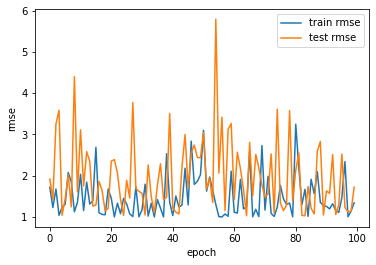

In [ ]:
##first checking the performance without adding features
train(data,epochs=100,model=LinearRegression(lr=0.01,num_iter=10),batch=64)

(1.3810973981883792, 1.5133359266192552)

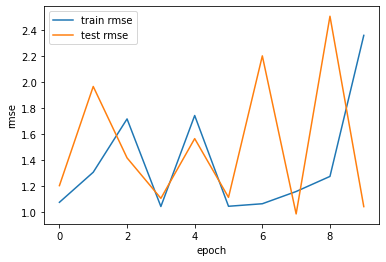

In [ ]:

df2=featureEngineering(data,2)

train(df2,epochs=100,model=LinearRegression(lr=0.01,num_iter=10),batch=64)

(1.3533009500151667, 2.2390602571636755)

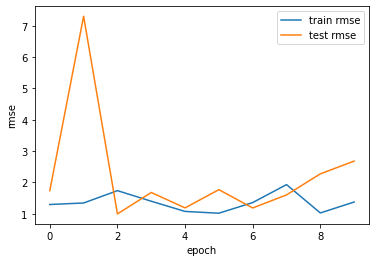

In [ ]:
df2=featureEngineering(data,3)

train(df2,epochs=100,model=LinearRegression(lr=0.01,num_iter=10),batch=64)

(1.5985196828134451, 1.9658169221735249)

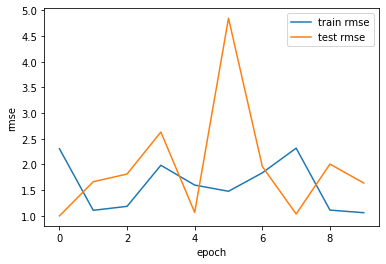

In [ ]:
##without regularization

df2=featureEngineering(data,4)
train(df2,epochs=100,model=LinearRegression(lr=0.01,num_iter=10),batch=64)

(1.2787342749862982, 1.7046391772414036)

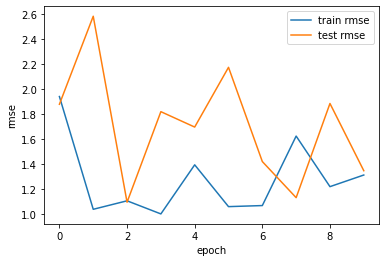

In [ ]:
##with regularization
df2=featureEngineering(data,4)
train(df2,epochs=10,model=LinearRegression(lr=0.01,num_iter=10,lamda2=20),batch=64)

#observation 
it can be observed clearly that as features increases( power 4 ), the difference between train and test error increases thus overfitting the model.Also adding these features didn't improve the training error in genaral

#Regularization hyperpatameter tuning

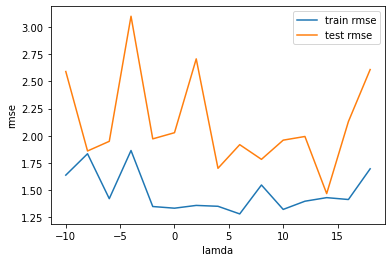

In [ ]:
lamda=range(-10,20,2)
rmse_train=[]
rmse_test=[]
for lamd in lamda:
  df2=featureEngineering(data,4)

  rmse_train.append(trainwithoutPlot(df2,epochs=10,model=LinearRegression(lr=0.01,num_iter=10,lamda2=lamd,lamda1=lamd),batch=64)[2])

  rmse_test.append(trainwithoutPlot(df2,epochs=10,model=LinearRegression(lr=0.01,num_iter=10,lamda2=lamd,lamda1=lamd),batch=64)[3])
plt.plot(lamda, rmse_train,label='train rmse')
plt.plot(lamda, rmse_test,label='test rmse')
plt.xlabel('lamda')
plt.ylabel('rmse')
plt.legend()

#observation
we notice that as we increase the regularization term in the complex model, the complexity reduces and thus the overfitting (test error approximately equals train error)

#Learning rate hyperpatameter tuning

[2.4695159661992565, 1.2310107447008496, 1.1835815202638509, 1.162434076447983, 1.159161768229248, 1.1559777531723183, 1.158611923077905, 1.15682236070789, 1.1554354528477093, 1.1547441295766252]


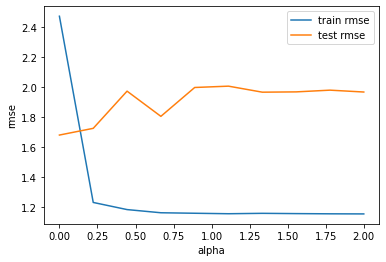

In [ ]:
lr=np.linspace(10**-10,2,10)
rmse_train=[]
rmse_test=[]
for l in lr:
  df2=standardize(data)

  rmse_train.append(trainwithoutPlot(df2,epochs=3,model=LinearRegression(lr=l,num_iter=10),batch=64)[2])

  rmse_test.append(trainwithoutPlot(df2,epochs=3,model=LinearRegression(lr=l,num_iter=10,),batch=64)[3])
print(rmse_train)
plt.plot(lr, rmse_train,label='train rmse')
plt.plot(lr, rmse_test,label='test rmse')
plt.xlabel('alpha')
plt.ylabel('rmse')
plt.legend()

#observation
increasing alpha beyond 0.9 led to very large values of rmse for both train and test which means huge divergence of weights and suggets underfitting 
also, rmse is to some extent constant for smaller values (til 0.8)

#Cross Validation

method1 using sampling from the data frame k times

In [ ]:
#--------------------------step5 k-fold-------------------------------------------------------#
def crossValidation(data,model,k=3,state=np.random.seed(10)):
  rmse_train=[]
  rmse_test=[]
  for fold in range(k):
    n=len(data)-int(len(data)/k)
    data=standardize(data)
    #sampling into train and test
    dataTrain=data.sample(n=n,random_state=state)
    dataTest=data.drop(dataTrain.index)
    # splitting x and y
    trainX=dataTrain.iloc[:,:-1]
    trainY=dataTrain.iloc[:,-1:]
    testX=dataTest.iloc[:,:-1]
    testY=dataTest.iloc[:,-1:]
    
    model.fitMBGD(trainX,trainY,batchsize=256)
    rmse_train.append(model.rmse(trainY.values,model.predict(trainX)[0]))
    rmse_test.append(model.rmse(testY.values,model.predict(testX)[0]))
    ##shuffling the data
    #data=data.sample(frac=1).reset_index(drop=True)
  return np.mean(rmse_train),np.mean(rmse_test)

In [ ]:
 model1=LinearRegression(lr=0.1,num_iter=10,lamda1=10)
 crossValidation(data,model1)

(1.395831340319875, 1.6992159203362505)

method2 by slicing x and y 

In [ ]:
#--------------------------step5 k-fold-------------------------------------------------------#
def crossValidation2(x,y,model,k=3,seed=(10)):
  rmse_train=[]
  rmse_test=[]
  size=x.shape[0]
  indxlist=list(range(size))
     ###shuffling 
  np.random.seed(10)
  shuffle(indxlist)
  n=int(size/k)
  for fold in range(k):
    ##in last iteration take the whole data
    if fold==k-1:
      idx=indxlist[fold*n:size]
    else:
      idx=indxlist[fold*n:(fold+1)*n]
    testX=x.iloc[idx,:]
    testY=y.iloc[idx,:]
    idxtrain=list(set(indxlist)-set(idx))
    trainX=x.iloc[idxtrain,:]
    trainY=y.iloc[idxtrain,:]
    model.fitMBGD(trainX,trainY,batchsize=256)
    rmse_train.append(model.rmse(trainY.values,model.predict(trainX)[0]))
    rmse_test.append(model.rmse(testY.values,model.predict(testX)[0]))
  
  return np.mean(rmse_train),np.mean(rmse_test)

In [ ]:
 model1=LinearRegression(lr=0.1,num_iter=10,lamda1=10)
 crossValidation2(trainX,trainY,model1)

(1.127792536959335, 1.260948134277742)

#Hyperparameters(lambda) tuning with cross validation

In [ ]:
#test different models of different lambada values and different types of regularization:
#the best model has the minimum rmse train and rmse test

lamdas=range(-10,10)
rmse_trainmin=100000 ##very large number
rmse_testmin=100000 ##very large number
modelopt=''
optimuml=0
for l in lamdas:
  model1=LinearRegression(lr=0.1,num_iter=100,lamda1=l)
  if crossValidation2(trainX,trainY,model1)[0]<rmse_trainmin and crossValidation2(trainX,trainY,model1)[1]<rmse_testmin :
    rmse_trainmin=crossValidation2(trainX,trainY,model1)[0]
    rmse_testmin=crossValidation2(trainX,trainY,model1)[1]
    optimuml=l
    modelopt='l1'
  model2=LinearRegression(lr=0.1,num_iter=100,lamda2=l)
  if crossValidation2(trainX,trainY,model2)[0]<rmse_trainmin and crossValidation2(trainX,trainY,model2)[1]<rmse_testmin :
    rmse_trainmin=crossValidation2(trainX,trainY,model2)[0]
    rmse_testmin=crossValidation2(trainX,trainY,model2)[1]
    optimuml=l
    modelopt='l2'
  model3=LinearRegression(lr=0.1,num_iter=100,lamda1=l,lamda2=l)
  if crossValidation2(trainX,trainY,model3)[0]<rmse_trainmin and crossValidation2(trainX,trainY,model3)[1]<rmse_testmin :
    rmse_trainmin=crossValidation2(trainX,trainY,model3)[0]
    rmse_testmin=crossValidation2(trainX,trainY,model3)[1]
    optimuml=l
    modelopt='elastic net'
print('the minimum train rmse is {:.2f} ,minumum test rmse is {:.2f} with lamda equal to {} obtained using {} regularizer'.format(rmse_trainmin,rmse_testmin,optimuml,modelopt))




the minimum train rmse is 1.11 ,minumum test rmse is 1.14 with lamda equal to 6 obtained using l2 regularizer


#Conclusion
after many experiments , i concluded that this data is not a good measure of what we taught about machine learning such as regularization ,difference between l1 and l2 , feature engineering among other things